In [ ]:
#Bill Koch DSE503 Project
# Please note that running this will require using a .env file to connect to a valid MySQL Server

# Generic library imports
import datetime, time, random, os
from datetime import timedelta
from dotenv import load_dotenv
import mysql.connector
import threading

# League of Legend specific libraries
import cassiopeia as cass
from cassiopeia.core import Summoner, MatchHistory, Match
from cassiopeia import Queue, Patch
from numpy.core.fromnumeric import shape
from riotwatcher import LolWatcher, ApiError

# Data science libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

load_dotenv()
cass.set_riot_api_key("RGAPI-e4883b64-5a1c-4879-b647-acaafe3ee187")


In [ ]:
def print_newest_match(name: str, region: str):
    summoner = Summoner(name=name, region=region)

    match_history = summoner.match_history
    match = match_history[0]
    print("Match ID:", match.id)

    print("Frame interval:", match.timeline.frame_interval)

    # The cumulative timeline property allows you to get some info about participants during the match.
    #  You access the cumulative timeline by providing the duration into the game that you want the info for.
    #  In this case, we're accessing the game at 15 minutes and 30 seconds.
    #  Some data is only available every one minute.
    p = match.participants[summoner]
    p_state = p.cumulative_timeline[datetime.timedelta(minutes=15, seconds=30)]
    # You can also use a string instead of datetime.timedelta
    p_state = p.cumulative_timeline["15:30"]
    items = p_state.items
    items = [item.name for item in items]
    skills = p_state.skills
    print("Champion:", p.champion.name)
    print("Items:", items)
    print("Skills:", skills)
    print("Kills:", p_state.kills)
    print("Deaths:", p_state.deaths)
    print("Assists:", p_state.assists)
    print("KDA:", p_state.kda)
    print("Level:", p_state.level)
    print("Position:", p_state.position)
    print("Exp:", p_state.experience)
    print("Number of objectives assisted in:", p_state.objectives)
    print("Gold earned:", p_state.gold_earned)
    print("Current gold:", p_state.current_gold)
    print("CS:", p_state.creep_score)
    print("CS in jungle:", p_state.neutral_minions_killed)

def print_summoner(name: str, region: str):
    summoner = Summoner(name=name, region=region)
    print("Name:", summoner.name)
    print("ID:", summoner.id)
    print("Account ID:", summoner.account_id)
    print("Level:", summoner.level)
    print("Revision date:", summoner.revision_date)
    print("Profile icon ID:", summoner.profile_icon.id)
    print("Profile icon name:", summoner.profile_icon.name)
    print("Profile icon URL:", summoner.profile_icon.url)
    print("Profile icon image:", summoner.profile_icon.image)

def get_player_stats(player):
    return np.array([player.summoner_spell_d.id, player.summoner_spell_f.id, player.champion.id, player.side, player.individual_position,
                        player.stats.assists, player.stats.damage_dealt_to_buildings, player.stats.damage_dealt_to_objectives,
                        player.stats.damage_dealt_to_turrets, player.stats.deaths, player.stats.gold_earned, player.stats.kda,
                        player.stats.kills, player.stats.level, player.stats.time_CCing_others, player.stats.total_damage_dealt,
                        player.stats.total_damage_taken, player.stats.total_minions_killed, player.stats.turret_kills,
                        player.stats.vision_score, player.stats.win])


def get_match_stats(match):
    match_stats = np.empty(shape = (0,21))
    players = match.participants
    # Random Summoner Choice to Ensure Independence
    random_summoner = random.choice(players)
    match_stats = np.r_[match_stats, [get_player_stats(random_summoner)]]
    return match_stats

def get_match_history_stats(history):
    history_stats = np.empty(shape = (0,21))
    for match in history:
        if match.duration < timedelta(minutes=15, seconds= 30):
            # skip remake and ff15
            pass
        else:
            history_stats = np.r_[history_stats, get_match_stats(match)]
    return history_stats


def get_summoner_list_stats(summoners, region):
    summoner_stats = np.empty(shape=(0,21))
    i = 0
    for summoner in summoners:
        i+= 1
        s = Summoner(name=summoner, region=region)
        match_history = cass.get_match_history(continent=s.region.continent, puuid=s.puuid, queue=Queue.ranked_solo_fives)
        summoner_stats = np.r_[summoner_stats, get_match_history_stats(match_history)]
        print(str(i) + ' Summoner')
        print('Sleep for 10 Seconds')
        time.sleep(10)
    return summoner_stats


def implement_data_dragon(data, api_key):
    watcher = LolWatcher(api_key)
    # check league's latest version
    latest = watcher.data_dragon.versions_for_region('na1')['n']['champion']
    # Lets get some champions static information
    static_champ_list = watcher.data_dragon.champions(latest, False, 'en_US')

    # champ static list data to dict for looking up
    champ_dict = {}
    for key in static_champ_list['data']:
        row = static_champ_list['data'][key]
        champ_dict[row['key']] = row['id']

    print(shape(champ_dict))

    for index, row in data.iterrows():
        row['champion'] = champ_dict[str(row['champion'])]

    return data

def get_challenger_accounts(locale):
    challenger_data = cass.get_challenger_league(cass.Queue.ranked_solo_fives, region=cass.Region(locale))
    names = []
    for s in challenger_data.entries:
        names.append(s.summoner.name)
    return names

def upload_to_do_db(data):
    closeit = False
    try:
        connection = mysql.connector.connect(host=os.getenv("HOST"),
                                             database=os.getenv("DATABASE"),
                                             user=os.getenv("USER"),
                                             password=os.getenv("PASSWORD"),
                                             port=int(os.getenv("PORT")),
                                             #SSLMODE="REQUIRED"
                                             )

        cursor = connection.cursor()
        #print(data['info']['gameId'])
        #print(data['info']['teams'][0]['win'])
        #cursor.execute("INSERT INTO games (gameId, win) VALUES (%s, %s)", (data['info']['gameId'], data['info']['teams'][0]['win']))
        cols = "`,`".join([str(i) for i in data.columns.tolist()])

        # Insert DataFrame records one by one.
        for i,row in data.iterrows():
            sql = "INSERT INTO `easymatches` (`" +cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
            # print(sql)
            # print(tuple(row))
            cursor.execute(sql, tuple(row))
        connection.commit()
        print("Successful upload")
        closeit = True
    except NameError:
        print("DB 'createGame' Issues... trying again...")
        print(NameError)
        sleep(1)
    finally:
        if closeit == True:
            connection.close()

def mp_datacollect(key, summoner_list, x):
    cass.set_riot_api_key(key)
    my_list = np.array_split(summoner_list, process_num)[x]
    data = pd.DataFrame(get_summoner_list_stats(my_list, "NA"), columns=np.array(['d_spell', 'f_spell', 'champion', 'side', 'role', 'assists', 'damage_objectives', 'damage_building', 'damage_turrets', 'deaths',
'gold_earned', 'kda', 'kills', 'level', 'time_cc', 'damage_total' , 'damage_taken', 'total_minions_killed', 'turret_kills', 'vision_score', 'result']))
    data = implement_data_dragon(data, key)


    data.to_csv('2match.csv', index=True, mode='a')
    data.to_csv('temp.csv', index=True)
    cols = pd.read_csv('temp.csv', nrows=1).columns
    data2 = pd.read_csv('temp.csv', usecols=cols[1:] )
    upload_to_do_db(data2)

In [ ]:
print_newest_match(name="Wicked Demiurge", region="NA")

Making call: https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/Wicked%20Demiurge
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/X3rH14Ua-KivIf_oZatvo9FrDNKkf7dNRgoJ_2-1ENJwOTNeUmM-T5lRt39xAu8eZCnzW8n9-smIuw/ids?beginIndex=0&endIndex=100
Match ID: NA1_4227584902
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4227584902/timeline
Frame interval: 60000
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4227584902
Making call: https://ddragon.leagueoflegends.com/realms/na.json
Making call: https://ddragon.leagueoflegends.com/cdn/12.9.1/data/en_US/item.json
Making call: https://cdn.merakianalytics.com/riot/lol/resources/patches.json
Making call: https://ddragon.leagueoflegends.com/api/versions.json
Making call: https://ddragon.leagueoflegends.com/cdn/12.4.1/data/en_US/championFull.json
Champion: Warwick
Items: ['Refillable Potion', 'Stealth Ward', 'Long Sword', 'Tiamat', 'Kindlegem', 'Plated Steelcap

In [ ]:
print_summoner("riskyliquid", "NA")

Name: riskyliquid
Making call: https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/riskyliquid
ID: ykZvwjuST24WD16tM7vfjtsHIXg2LGlArxp3-XWLvB4
Account ID: w2jhrl0spERl4CxLKie2eYr13PUUTmhgRUvCAu4zFQ
Level: 31
Revision date: 2021-08-06T00:17:15+00:00
Profile icon ID: 0
Profile icon name: None
Profile icon URL: https://ddragon.leagueoflegends.com/cdn/12.9.1/img/profileicon/0.png
Making call: https://ddragon.leagueoflegends.com/cdn/12.9.1/img/profileicon/0.png
Profile icon image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x19CB4F13B50>


In [ ]:
perfdata = pd.DataFrame(columns = ['NumRecords', 'TimeSpent', 'Type'])
start = time.time()
num_matches = 5
summoner_list = random.sample(get_challenger_accounts("EUW"), num_matches)
data = pd.DataFrame(get_summoner_list_stats(summoner_list), columns=np.array(['d_spell', 'f_spell', 'champion', 'side', 'role', 'assists', 'damage_objectives', 'damage_building', 'damage_turrets', 'deaths',
'gold_earned', 'kda', 'kills', 'level', 'time_cc', 'damage_total' , 'damage_taken', 'total_minions_killed', 'turret_kills', 'vision_score', 'result']))

data = implement_data_dragon(data, "RGAPI-1456aea6-b834-4cad-9549-e6ed52c85ef1")


data.to_csv('2match.csv', index=True, mode='a')
data.to_csv('temp.csv', index=True)
num_entries = 0
cols = pd.read_csv('temp.csv', nrows=1).columns
data2 = pd.read_csv('temp.csv', usecols=cols[1:] )
upload_to_do_db(data2)

end = time.time()
duration = end - start

d = {'NumRecords':[num_matches], 'TimeSpent':[duration], 'Type': ["serial"]}
perfdata = pd.DataFrame(data=d)
perfdata.to_csv('performance.csv', index=True, mode='a')

Making call: https://euw1.api.riotgames.com/lol/summoner/v4/summoners/7Itx-MaFY7ueaofqtxHNgaTTeTtRaJ4P5bvskZbsu1_eLCMZ
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/jeXaHn5IZmRHdNMFTsCeowpJlo_rwZQx9foMDJqUXWgozaHndatYzcW6vG2CdQ7ClTXfDhmOeohDWA/ids?beginIndex=0&endIndex=100&queue=420
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5860943681
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5859614591
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5859534505
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5859276471
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5858800371
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5858784618
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5858698237
Making call: https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_5854538394
Making call: https://e

In [ ]:
import threading
start = time.time()
perfdata = pd.DataFrame(columns = ['NumRecords', 'TimeSpent', 'Type'])
process_num = 2
num_matches = 3*process_num
summoner_list = random.sample(get_challenger_accounts("NA"), num_matches)
key = "RGAPI-e4883b64-5a1c-4879-b647-acaafe3ee187"

threads = []
for i in range(process_num):
    t = threading.Thread(target=mp_datacollect, args=(key, summoner_list,i,))
    threads.append(t)
    t.start()
    t.join()
end = time.time()
duration = end - start

d = {'NumRecords':[num_matches], 'TimeSpent':[duration], 'Type': ["parallel"]}
perfdata = pd.DataFrame(data=d)
perfdata.to_csv('performance.csv', index=True, mode='a')

In [ ]:
perf_df = pd.read_csv('performance_cleaned.csv')
perf_df['avgtime'] = perf_df.TimeSpent / perf_df.NumRecords
perf_df['avgtime'].convert_dtypes(float)
ax = perf_df.loc[perf_df['Type'] == 'serial']
bx = perf_df.loc[perf_df['Type'] == 'parallel']

a = []
for index, row in ax.iterrows():
    for i in range(row['NumRecords']):
        a.append(row['avgtime'])

b = []
for index, row in bx.iterrows():
    for i in range(row['NumRecords']):
        b.append(row['avgtime'])

[25.46713758,
 28.171439600000003,
 28.0701572,
 21.266121480000002,
 24.15159822,
 24.13272614,
 24.27898454]

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# Calculate the T-test for the means of two independent samples of scores.

# This is a test for the null hypothesis that 2 independent samples have identical average (expected) values.
# This test assumes that the populations have identical variances by default.

# H0 = Systems are identical = uA=uB
# HA = System A is better than System B (one sided test)

print(len(a), ' tests on System A')
print(len(b), ' tests on System B')

print("Mean response time (lower is better)")
print("System A:", '%.4g' % np.mean(a))
print("System B:", '%.4g' % np.mean(b))

t_statistic, p_value = stats.ttest_ind(a, b) # equal_var defaults to True
print('Assume equal variances:')
print("t-statistic =", '%.3g' % t_statistic)
print("p-value =", '%.3g' % p_value)
print("")

t_statistic, p_value = stats.ttest_ind(a, b, equal_var=False)
print('Assume unequal variances:')
print("t-statistic =", '%.3g' % t_statistic)
print("p-value =", '%.3g' % p_value)

# Large p-value --> accept the null hypothesis of equal population means

31  tests on System A
48  tests on System B
Mean response time (lower is better)
System A: 25.03
System B: 23.79
Assume equal variances:
t-statistic = 2.14
p-value = 0.0354

Assume unequal variances:
t-statistic = 2.17
p-value = 0.0339


In [ ]:
match_df = pd.read_csv('1280matchdata.csv')
match_df = match_df[['damage_objectives', 'kda', 'gold_earned', 'damage_total', 'vision_score', 'result']]
match_df.head()

,damage_objectives,kda,gold_earned,damage_total,vision_score,result
0,4615,10.0,12114,138182,22,1
1,616,19.0,7812,20236,43,1
2,8612,20.0,10028,89272,10,1
3,5800,4.0,10868,140468,9,1
4,279,2.5,5684,12711,52,0


                   damage_objectives       kda  gold_earned  damage_total  \
damage_objectives           1.000000  0.189865     0.556113      0.498265   
kda                         0.189865  1.000000     0.153434      0.036862   
gold_earned                 0.556113  0.153434     1.000000      0.851166   
damage_total                0.498265  0.036862     0.851166      1.000000   
vision_score               -0.163263  0.114333     0.041770     -0.225122   
result                      0.370072  0.529587     0.289011      0.145199   

                   vision_score    result  
damage_objectives     -0.163263  0.370072  
kda                    0.114333  0.529587  
gold_earned            0.041770  0.289011  
damage_total          -0.225122  0.145199  
vision_score           1.000000  0.049016  
result                 0.049016  1.000000  


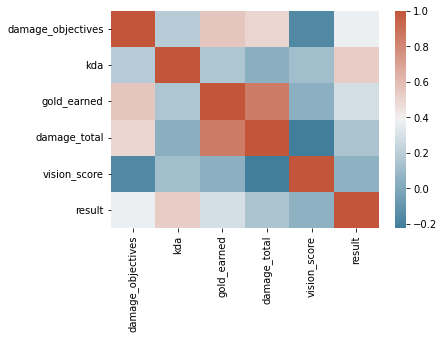

In [ ]:
print(match_df.corr())
ax = sns.heatmap(match_df.corr(), cmap= sns.diverging_palette(230, 20, as_cmap=True))

In [ ]:
match_df.corr()

,damage_objectives,kda,gold_earned,damage_total,vision_score,result
damage_objectives,1.000000,0.189865,0.556113,0.498265,-0.163263,0.370072
kda,0.189865,1.000000,0.153434,0.036862,0.114333,0.529587
gold_earned,0.556113,0.153434,1.000000,0.851166,0.041770,0.289011
damage_total,0.498265,0.036862,0.851166,1.000000,-0.225122,0.145199
vision_score,-0.163263,0.114333,0.041770,-0.225122,1.000000,0.049016
result,0.370072,0.529587,0.289011,0.145199,0.049016,1.000000
